In [1]:
{
    "tags": [
        "hide-input",
    ]
}
!{sys.executable} -m pip install  pygsheets
!{sys.executable} -m pip install --upgrade pyarrow
#get data
import pygsheets
import configparser
import sys
import snowflake.connector
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import numpy as np                   # v 1.19.2
import matplotlib.pyplot as plt      # v 3.3.2
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
# calculate the net_arr bucket of open deals
import seaborn as sns
from math import floor 
#NF Jupyter is not recognizing the right folder. Needed to set it up manually
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from gitlabdata.orchestration_utils import (
    data_science_engine_factory,
    query_dataframe,
)

engine = data_science_engine_factory()

service_file_path = '/Volumes/GoogleDrive-101341343143168722397/My Drive/docker_work/jupyter_analysis/20220210_FY22_channel_value_analysis/nfiguera-c3fe9e64-a6543dd51e79.json'

#target gsheet for uploads and downloads, just allowing one to keep it more secure
spreadsheet_id = '1-TO3GATTq240IOafNqZTAi9ixmvdeDUzotAYlSMtFeU'



# Get the current working directory
cwd = os.getcwd()
print(cwd)
os.chdir("/Volumes/GoogleDrive-101341343143168722397/My Drive/docker_work/jupyter_analysis/20220223_CoverageCurves/")

#how to add access to gsheet
#https://stackoverflow.com/questions/62917910/python-export-pandas-dataframe-to-google-sheets-solved

zsh:1: parse error near `-m'
zsh:1: parse error near `-m'


/Users/nfiguera/.local/share/virtualenvs/data-science-mn1T8veA/lib/python3.8/site-packages/snowflake/connector/options.py:94: UserWarning: You have an incompatible version of 'pyarrow' installed (7.0.0), please install a version that adheres to: 'pyarrow<5.1.0,>=5.0.0; extra == "pandas"'
  warn_incompatible_dep(


/Volumes/GoogleDrive-101341343143168722397/My Drive/docker_work/jupyter_analysis/20220223_CoverageCurves


In [2]:
import os as os
os.getcwd()

'/Volumes/GoogleDrive-101341343143168722397/My Drive/docker_work/jupyter_analysis/20220223_CoverageCurves'

# Helper Functions

In [3]:
#######
## Create a fitter curve of the last 4 quarters for comparison
#######
def objective(x, a, b, c, d, e):
    return a * x + b * x**2 + c * x**3 + d * x**4 + e


def write_to_gsheet(service_file_path, spreadsheet_id, sheet_name, data_df):
    """
    this function takes data_df and writes it under spreadsheet_id
    and sheet_name using your credentials under service_file_path
    """
    gc = pygsheets.authorize(service_file=service_file_path)
    sh = gc.open_by_key(spreadsheet_id)
    try:
        sh.add_worksheet(sheet_name)
    except:
        pass
    wks_write = sh.worksheet_by_title(sheet_name)
    wks_write.clear('A1',None,'*')
    wks_write.set_dataframe(data_df, (1,1), encoding='utf-8', fit=True)
    wks_write.frozen_rows = 1

def read_from_gsheet(service_file_path, spreadsheet_id, sheet_name):
    """
    this function takes a sheet_name from a spreadsheet_id and returns a data frame 
    """
    gc = pygsheets.authorize(service_file=service_file_path)
    sh = gc.open_by_key(spreadsheet_id)
   
    wks_read = sh.worksheet_by_title(sheet_name)
    read = wks_read.get_as_df()
    
    return read


def run_query_in_snowflake(conn, sql):
    cur = conn.cursor()
    cur.execute(sql)
    df = cur.fetch_pandas_all()
    return df

def executeScriptFromFile(filename, engine):
    # Open and read the file as a single buffer
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()
    
    results = -1
    
    try:
        results = query_dataframe(engine,sqlFile)
    except:
        print("Command did not run")
    
    return results

###########################################################

def days_between(d1, d2):
    #d1 = datetime.strptime(d1, "%Y-%m-%d")
    #d2 = datetime.strptime(d2, "%Y-%m-%d")
    return (d2 - d1).days


def calculate_quarters_after_creation(x):
        
    age = 0
    
    if (x['IS_OPEN'] == 1):
        age = days_between(x['CREATED_FISCAL_QUARTER_DATE'], x['SNAPSHOT_FISCAL_QUARTER_DATE'])
    elif (x['IS_OPEN']== 0 and x['SNAPSHOT_DATE'] <= x['CLOSE_DATE']):
        age = days_between(x['CREATED_FISCAL_QUARTER_DATE'], x['SNAPSHOT_FISCAL_QUARTER_DATE'])
    else:
        age = days_between(x['CREATED_FISCAL_QUARTER_DATE'], x['CLOSE_FISCAL_QUARTER_DATE'])
    
    quarter_delta = floor(age/90)
    
    return quarter_delta

def calculate_channel_track (x):
    
    channel_track = 'Direct'
    
    if (x['deal_path'] == 'Direct'):
        channel_track = 'Direct'
    elif (x['deal_path'] == 'Web Direct'):
        channel_track = 'Web Direct'
    elif (x['deal_path'] == 'Channel'
        and x['sales_qualified_source'] != 'Channel Generated'): 
        channel_track = 'Partner Co-Sell'
    elif (x['deal_path'] == 'Channel'):
        channel_track = 'Partner Sourced'
    
    return channel_track

In [4]:
# calculates pending coverage using a minimum of 50k pending
def calculate_to_pending_coverage (x, metric, qtd, actual, minimum_delta=5000):
    
    result = None
    
    actual = float(x[actual])
    qtd = float(x[qtd])
    metric = float(x[metric])
    
    if (actual - qtd) > minimum_delta:
        result = metric / (actual - qtd)
    return result

# calculate the metrics based on a dictionary that is passed as a parameter
def calculate_metric_coverages (agg_data, dict_metrics):

    # considered metrics for the specific calculation
    metrics_variable = dict_metrics['considered_metrics']
    # variables that track quarter actual (total) at the end of the quarter
    actuals_variable = dict_metrics['actual_metric']
    # variables that track quarter to date values, when calculating coverage to pending this is required
    to_date_variable = dict_metrics['qtd_metric']

    # calculate pending coverage
    for metric in metrics_variable:
        agg_data[metric+'_coverage'] = agg_data.apply(calculate_to_pending_coverage, axis=1,metric=metric,qtd=to_date_variable,actual=actuals_variable)
    
    agg_data.dropna(inplace=True)
    return agg_data

# fits a curve to the subset data using the defined objective function
def fit_curve_to_agg (data_agg, x_label, y_label):
    
    # fit a curve
    x, y = data_agg[x_label], data_agg[y_label]
    # curve fit
    popt, _ = curve_fit(objective, x, y)

    x_line = np.arange(min(x), max(x), 1)
    # calculate the output for the range
    # summarize the parameter values
    a, b, c , d, e = popt
    y_line = objective(x_line, a, b, c, d, e)
  
    curve_result = pd.DataFrame({x_label:x_line,y_label:y_line})
    return curve_result

## Data Collection

In [5]:
metrics_by_day_db = executeScriptFromFile('metrics_by_day.sql', engine)
#metrics_by_day_db.to_csv('metrics_by_day.csv')

In [6]:
metrics_by_day_db.close_fiscal_quarter_name.sort_values().unique()

array(['FY20-Q3', 'FY20-Q4', 'FY21-Q1', 'FY21-Q2', 'FY21-Q3', 'FY21-Q4',
       'FY22-Q1', 'FY22-Q2', 'FY22-Q3', 'FY22-Q4', 'FY23-Q1', 'FY23-Q2',
       'FY23-Q3', 'FY23-Q4'], dtype=object)

In [7]:
metrics_by_day_db[(metrics_by_day_db['close_fiscal_quarter_name'] == 'FY23-Q1') & (metrics_by_day_db['close_day_of_fiscal_quarter_normalised'] == 23)].pipe_gen_net_arr.sum()

31373179.2

In [42]:
# identify the quarters that will be considered when creating the curves
# for current quarter last 4 quarters
index_cond = (metrics_by_day_db['close_fiscal_quarter_date'] <= date.today() + relativedelta(months=-3)) & (metrics_by_day_db['close_fiscal_quarter_date'] >= date.today() + relativedelta(months=-15))
cq_considered_quarters = metrics_by_day_db[index_cond].close_fiscal_quarter_name.sort_values().unique()

# for current quarter + 1, between 5 and 1 quarter ago (as we need the total won amount of the quarter to calculate coverage)
index_cond = (metrics_by_day_db['close_fiscal_quarter_date'] <= date.today() + relativedelta(months=-6)) & (metrics_by_day_db['close_fiscal_quarter_date'] >= date.today() + relativedelta(months=-18))
cq_1plus_considered_quarters = metrics_by_day_db[index_cond].close_fiscal_quarter_name.sort_values().unique()

# for current quarter + 2, between 6 and 2 quarter ago (as we need the total won amount of the quarter to calculate coverage)
index_cond = (metrics_by_day_db['close_fiscal_quarter_date'] <= date.today() + relativedelta(months=-9)) & (metrics_by_day_db['close_fiscal_quarter_date'] >= date.today() + relativedelta(months=-21))
cq_2plus_considered_quarters = metrics_by_day_db[index_cond].close_fiscal_quarter_name.sort_values().unique()

print(cq_considered_quarters)
print(cq_1plus_considered_quarters)
print(cq_2plus_considered_quarters)

['FY22-Q1' 'FY22-Q2' 'FY22-Q3' 'FY22-Q4']
['FY21-Q4' 'FY22-Q1' 'FY22-Q2' 'FY22-Q3']
['FY21-Q3' 'FY21-Q4' 'FY22-Q1' 'FY22-Q2']


In [45]:
# separate considered data points per metric type
cq_metrics_data = metrics_by_day_db[metrics_by_day_db['close_fiscal_quarter_name'].isin(cq_considered_quarters)].copy()
cq_plus1_metrics_data = metrics_by_day_db[metrics_by_day_db['close_fiscal_quarter_name'].isin(cq_1plus_considered_quarters)].copy()
cq_plus2_metrics_data = metrics_by_day_db[metrics_by_day_db['close_fiscal_quarter_name'].isin(cq_2plus_considered_quarters)].copy()

In [86]:
cq_plus2_metrics_data.groupby(['close_fiscal_quarter_name','close_day_of_fiscal_quarter_normalised'])['rq_plus_2_open_1plus_net_arr'].sum()

close_fiscal_quarter_name  close_day_of_fiscal_quarter_normalised
FY21-Q3                    -1                                        0.000000e+00
                            0                                        0.000000e+00
                            1                                        2.234026e+07
                            2                                        2.245953e+07
                            3                                        2.237671e+07
                                                                         ...     
FY22-Q2                     86                                       1.049558e+08
                            87                                       1.081690e+08
                            88                                       1.075066e+08
                            89                                       1.103145e+08
                            90                                       1.103741e+08
Name: rq_plus_2_open_1plus_net_a

In [87]:
# There are three fields that are critical
# - Open Pipe Net ARR (Stage 1, 3, 4) (These can be metrics in a tall table)
# - Booked Amount (This could be a column)
# - Total Booked Amount (This can also be a column)

### considered keys
agg_key_list = ['key_segment',
       'key_sqs', 'key_ot', 'key_segment_geo', 'key_segment_geo_sqs',
       'key_segment_geo_ot', 'key_segment_geo_region',
       'key_segment_geo_region_sqs', 'key_segment_geo_region_ot',
       'key_segment_geo_region_area', 'key_segment_geo_region_area_sqs',
       'key_segment_geo_region_area_ot','report_user_segment_geo_region_area']

### current quarter
variables = ['close_day_of_fiscal_quarter_normalised','close_fiscal_quarter_name','total_booked_net_arr','booked_net_arr'] + agg_key_list
considered_metrics = ['open_1plus_net_arr','open_3plus_net_arr','open_4plus_net_arr'] 
cq_melt = cq_metrics_data.melt(id_vars = variables, value_vars = considered_metrics)

### current quarter + 1 
variables = ['close_day_of_fiscal_quarter_normalised','close_fiscal_quarter_name','rq_plus_1_total_booked_net_arr','booked_net_arr'] + agg_key_list 
considered_metrics = ['rq_plus_1_open_1plus_net_arr', 'rq_plus_1_open_3plus_net_arr',
       'rq_plus_1_open_4plus_net_arr']
cq_plus1_melt = cq_plus1_metrics_data.melt(id_vars = variables, value_vars = considered_metrics)
# rename the total booked field to keep it consistent
cq_plus1_melt = cq_plus1_melt.rename({'rq_plus_1_total_booked_net_arr':'total_booked_net_arr'}, axis=1)
cq_plus1_melt['booked_net_arr'] = 0

### current quarter + 2
variables = ['close_day_of_fiscal_quarter_normalised','close_fiscal_quarter_name','rq_plus_2_total_booked_net_arr','booked_net_arr'] + agg_key_list
considered_metrics = ['rq_plus_2_open_1plus_net_arr', 'rq_plus_2_open_3plus_net_arr',
       'rq_plus_2_open_4plus_net_arr']
cq_plus2_melt = cq_plus2_metrics_data.melt(id_vars = variables, value_vars = considered_metrics)
# rename the total booked field to keep it consistent
cq_plus2_melt = cq_plus2_melt.rename({'rq_plus_2_total_booked_net_arr':'total_booked_net_arr'}, axis=1)
cq_plus2_melt['booked_net_arr'] = 0

### consolidated dataset
combined_df = pd.concat([cq_melt, cq_plus1_melt,cq_plus2_melt], ignore_index=True)
combined_df = combined_df.rename({'variable':'metric_name'}, axis=1)
combined_df = combined_df.rename({'value':'metric_value'}, axis=1)

##########################################################
# to be able to calculate coverage, we need to drop:
# - Lines where total booked net arr = 0
# - Lines where value is NaN or 0
# - Lines where booked_net_arr is NaN are to be set to 0

###
# - Lines where total booked net arr = 0
# - Lines where value is NaN or 0
combined_df.dropna(subset=['total_booked_net_arr', 'metric_value'], inplace=True)

# - Lines where booked_net_arr is NaN are to be set to 0
# combined_df = combined_df.drop(combined_df[combined_df['total_booked_net_arr']==0].index)
len(combined_df)

# test result
print(len(combined_df), ' # of rows - ', combined_df.columns)

2015208  # of rows -  Index(['close_day_of_fiscal_quarter_normalised', 'close_fiscal_quarter_name',
       'total_booked_net_arr', 'booked_net_arr', 'key_segment', 'key_sqs',
       'key_ot', 'key_segment_geo', 'key_segment_geo_sqs',
       'key_segment_geo_ot', 'key_segment_geo_region',
       'key_segment_geo_region_sqs', 'key_segment_geo_region_ot',
       'key_segment_geo_region_area', 'key_segment_geo_region_area_sqs',
       'key_segment_geo_region_area_ot', 'report_user_segment_geo_region_area',
       'metric_name', 'metric_value'],
      dtype='object')


In [88]:
combined_df.metric_name.unique()

array(['open_1plus_net_arr', 'open_3plus_net_arr', 'open_4plus_net_arr',
       'rq_plus_1_open_1plus_net_arr', 'rq_plus_1_open_3plus_net_arr',
       'rq_plus_1_open_4plus_net_arr', 'rq_plus_2_open_1plus_net_arr',
       'rq_plus_2_open_3plus_net_arr', 'rq_plus_2_open_4plus_net_arr'],
      dtype=object)

In [89]:
#combined_df.groupby(['key_segment', 'metric_name', 'close_day_of_fiscal_quarter_normalised', 'close_fiscal_quarter_name'])[['metric_value', 'total_booked_net_arr', 'booked_net_arr']].agg('sum').reset_index().metric_name.unique()
print(combined_df.groupby(['key_segment', 'metric_name', 'close_day_of_fiscal_quarter_normalised', 'close_fiscal_quarter_name'],dropna=False).agg({'metric_value':'sum','total_booked_net_arr':'sum','booked_net_arr':'sum'}).reset_index().metric_name.unique())


['open_1plus_net_arr' 'open_3plus_net_arr' 'open_4plus_net_arr'
 'rq_plus_1_open_1plus_net_arr' 'rq_plus_1_open_3plus_net_arr'
 'rq_plus_1_open_4plus_net_arr' 'rq_plus_2_open_1plus_net_arr'
 'rq_plus_2_open_3plus_net_arr' 'rq_plus_2_open_4plus_net_arr']


In [90]:
#########
# list of all the cuts we want to calculate coverage at
# coverage needs to be calculated at each cut independently as it cannot be added
agg_key_list = ['key_segment','key_sqs', 'key_ot', 'key_segment_geo', 'key_segment_geo_sqs', 
                   'key_segment_geo_ot', 'key_segment_geo_region',
                   'key_segment_geo_region_sqs', 'key_segment_geo_region_ot',
                   'key_segment_geo_region_area']

# aggregation columns
agg_columns = ['metric_name','close_day_of_fiscal_quarter_normalised', 'close_fiscal_quarter_name']
# fields to be summarized
agg_fields = ['metric_value','total_booked_net_arr', 'booked_net_arr']

# initialize to none, add. intermediate dataframes
# the goal is to calcualte the coverage for each aggregation key. First the data needs to be grouped
# at that level and the relevant fields summed up. Then the coverage calculation function is used
combined_agg_results = None
for agg_key in agg_key_list:
    
    # the key for aggregation needs to be complimented by the day key and the quarter key
    total_agg_keys = [agg_key] + agg_columns

    #calculate the aggregation per key
    temp = combined_df.groupby(total_agg_keys,dropna=False)[agg_fields].agg('sum').reset_index().copy()
    # calculate coverages per metric, all are calculated using the "Pending" approach
    # this needs to be done for every iteration 
    temp['metric_coverage'] = temp.apply(calculate_to_pending_coverage, axis=1,metric='metric_value',qtd='booked_net_arr',actual='total_booked_net_arr')

    # clean up / add information regarding the agg key
    temp = temp.rename({agg_key:'agg_key_value'},axis=1)
    temp['agg_key_name'] = agg_key

    #consolidate results
    if combined_agg_results is None:
        combined_agg_results = temp.copy()
    else:
        combined_agg_results = combined_agg_results.append(temp) 

# Calculation of Curve Fit

The previous step created a combined result data where we have a pre-aggregated and precalculated coverage for each value of the distinct aggregations keys.

To use this dataset we must filter by the value of the key we want to use e.g. Large and plot the metric_coverage field. 

The dataset has 4 data points per metric, as we consider 4 past quarters.

In [112]:
### Curve Fitting per Cut
# before this, the data needs to be aggredated and coverage calculated

# for this to run I need to filter a) they aggregation level, b) the specific value at that aggregation level.
# the result will be a table like key_agg, day_metric, 

#initialization
combined_fitted_results = None

#iterate through all the aggregated keys
for agg_key_name in combined_agg_results.agg_key_name.unique():

    #filter temporary data
    temp_key_data = combined_agg_results[combined_agg_results['agg_key_name']==agg_key_name].copy()
    
    #iterate through the unique values of the specific aggregation
    for agg_key_value in temp_key_data.agg_key_value.unique():
        
        # filter specific value per agg temporary data
        temp_key_value_data = temp_key_data[temp_key_data['agg_key_value']==agg_key_value].copy()
                
        # set up the range of the quarter curves we want to report on
        metrics_temp = pd.DataFrame({"close_day_of_fiscal_quarter_normalised":range(0,91)})

        for metric_name in temp_key_value_data.metric_name.unique():
            
            # drop nas
            temp_metric_data = temp_key_value_data[temp_key_value_data['metric_name']==metric_name].copy()
            temp_metric_data.dropna(subset=['metric_coverage'], inplace=True)
            temp_cuve = None
            # avoid fitting curves for cuts that do not have enough data
            if len(temp_metric_data) > 180:     
                temp_curve = fit_curve_to_agg (temp_metric_data,'close_day_of_fiscal_quarter_normalised','metric_coverage') 
                temp_curve.rename({'metric_coverage':metric_name+'_coverage'},inplace=1,axis=1)   
                metrics_temp =  metrics_temp.merge(temp_curve, how='left', on='close_day_of_fiscal_quarter_normalised')
 
              
            else:
                print(agg_key_value, ' - Has not enough data: ', len(temp_metric_data))              
            
        # add the metric detail to the dataset
        metrics_temp['agg_key_name'] = agg_key_name
        metrics_temp['agg_key_value'] = agg_key_value
        
        #consolidate results
        if combined_fitted_results is None:
            combined_fitted_results = metrics_temp.copy()
        else:
            combined_fitted_results = combined_fitted_results.append(metrics_temp) 
        
        combined_fitted_results.dropna()
        
combined_fitted_results

jihu  - Has not enough data:  178
jihu  - Has not enough data:  178
jihu  - Has not enough data:  178
jihu  - Has not enough data:  180
jihu  - Has not enough data:  180
jihu  - Has not enough data:  180
na  - Has not enough data:  0
na  - Has not enough data:  0
na  - Has not enough data:  0
na  - Has not enough data:  90
na  - Has not enough data:  90
na  - Has not enough data:  90
na  - Has not enough data:  180
na  - Has not enough data:  180
na  - Has not enough data:  180
other  - Has not enough data:  0
other  - Has not enough data:  0
other  - Has not enough data:  0
jihu_jihu  - Has not enough data:  178
jihu_jihu  - Has not enough data:  178
jihu_jihu  - Has not enough data:  178
jihu_jihu  - Has not enough data:  180
jihu_jihu  - Has not enough data:  180
jihu_jihu  - Has not enough data:  180
mid-market_global  - Has not enough data:  0
mid-market_global  - Has not enough data:  0
mid-market_global  - Has not enough data:  0
mid-market_global  - Has not enough data:  0
mid-

,close_day_of_fiscal_quarter_normalised,rq_plus_1_open_1plus_net_arr_coverage,rq_plus_1_open_3plus_net_arr_coverage,rq_plus_1_open_4plus_net_arr_coverage,agg_key_name,agg_key_value,open_1plus_net_arr_coverage,open_3plus_net_arr_coverage,open_4plus_net_arr_coverage,rq_plus_2_open_1plus_net_arr_coverage,rq_plus_2_open_3plus_net_arr_coverage,rq_plus_2_open_4plus_net_arr_coverage
0,0,NaN,NaN,NaN,key_segment,jihu,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.076445,0.077332,-4.940656e-324,key_segment,jihu,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.055419,0.056306,-4.940656e-324,key_segment,jihu,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.036619,0.037506,-4.940656e-324,key_segment,jihu,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.019947,0.020833,-4.940656e-324,key_segment,jihu,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,NaN,NaN,NaN,key_segment_geo_region_area,smb_global_sales admin_global,NaN,NaN,NaN,NaN,NaN,NaN
87,87,NaN,NaN,NaN,key_segment_geo_region_area,smb_global_sales admin_global,NaN,NaN,NaN,NaN,NaN,NaN
88,88,NaN,NaN,NaN,key_segment_geo_region_area,smb_global_sales admin_global,NaN,NaN,NaN,NaN,NaN,NaN
89,89,NaN,NaN,NaN,key_segment_geo_region_area,smb_global_sales admin_global,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
combined_fitted_results.head()

AttributeError: 'NoneType' object has no attribute 'head'

# Test Code

The following snippets were used during development to test the approach

<AxesSubplot:xlabel='close_day_of_fiscal_quarter_normalised', ylabel='metric_coverage'>

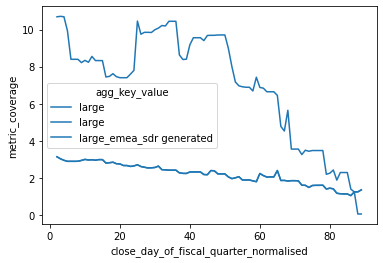

In [88]:
######## Test that the totals work. E.g. FY22Q4 Large = 29043057
# combined_df[(combined_df['close_day_of_fiscal_quarter_normalised']==40) & (combined_df['metric']=='open_1plus_net_arr')].groupby(by=['key_segment','close_fiscal_quarter_name']).total_booked_net_arr.sum()

####### Test that the coverage curve makes sense for one metric
index = (combined_df['key_segment']=='large') & (combined_df['metric_name']=='open_1plus_net_arr') & (combined_df['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_df[index].groupby(['close_day_of_fiscal_quarter_normalised','key_segment']).agg({'total_booked_net_arr':'sum','metric_value':'sum','booked_net_arr':'sum'}).reset_index()

# calculate coverages per metric, all are calculated using the "Pending" approach
# this needs to be done for every iteration 
temp['metric_coverage'] = temp.apply(calculate_to_pending_coverage, axis=1,metric_name='metric_value',qtd='booked_net_arr',actual='total_booked_net_arr')

sns.lineplot(data=temp,hue='key_segment', y='metric_coverage',x='close_day_of_fiscal_quarter_normalised')

#### Test #1 that combined pre-grouped dataset has reasonable values
combined_agg_results.head()
index = (combined_agg_results['agg_key_value']=='large') & (combined_agg_results['metric_name']=='open_1plus_net_arr') & (combined_agg_results['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_agg_results[index]
temp.head()
sns.lineplot(data=temp,hue='agg_key_value', y='metric_coverage',x='close_day_of_fiscal_quarter_normalised')


<AxesSubplot:xlabel='close_day_of_fiscal_quarter_normalised', ylabel='metric_coverage'>

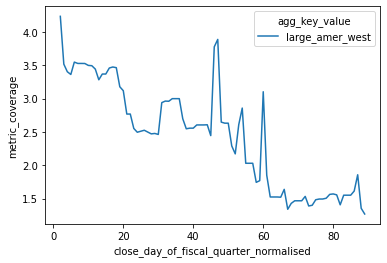

In [90]:

#### Test #2 that combined pre-grouped dataset has reasonable values
combined_agg_results.head()
index = (combined_agg_results['agg_key_value']=='large_amer_west') & (combined_agg_results['metric']=='open_1plus_net_arr') & (combined_agg_results['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_agg_results[index]
temp.head()
sns.lineplot(data=temp,hue='agg_key_value', y='metric_coverage',x='close_day_of_fiscal_quarter_normalised')

<AxesSubplot:xlabel='close_day_of_fiscal_quarter_normalised', ylabel='open_1plus_net_arr_coverage'>

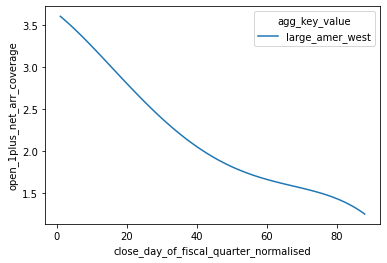

In [115]:
#### Test #3 that combined pre-grouped dataset has reasonable values
combined_fitted_results.head()
index = (combined_fitted_results['agg_key_value']=='large_amer_west')
temp = combined_fitted_results[index]
temp.head()
sns.lineplot(data=temp,hue='agg_key_value', y='open_1plus_net_arr_coverage',x='close_day_of_fiscal_quarter_normalised')

In [268]:
#### Coverage Calculation per Quarter
dict_temp = dict_metrics[0]

#prepare the data for being used
#this needs to be done for every key
x_variable = dict_temp['timeframe_day']
# considered metrics for the specific calculation
y_variable = dict_temp['considered_metrics']
# quarter date variable
quarter_variable = dict_temp['timeframe_quarter']

combined_agg_results = None

# list of all the variables to aggregate
total_variables =  y_variable + [actuals_variable] + [to_date_variable]
for agg_key in agg_key_list:
    
    # the key for aggregation needs to be complimented by the day key and the quarter key
    total_agg_keys = [x_variable , quarter_variable, agg_key]
    
    #calculate the aggregation per key
    temp = cq_metrics_data.groupby(total_agg_keys)[total_variables].agg('sum').reset_index()
    # calculate coverages per line
    temp = calculate_metric_coverages(temp,dict_temp)
    # clean up / add information regarding the agg key
    temp = temp.rename({agg_key:'value'},axis=1)
    temp['agg_key_name'] = agg_key

    #consolidate results
    if combined_agg_results is None:
        combined_agg_results = temp.copy()
    else:
        combined_agg_results = combined_agg_results.append(temp) 




In [270]:
dict_metrics = [
         {'metric':'Net ARR CQ',
          'actual_metric':'total_booked_net_arr',
          'qtd_metric':'booked_net_arr',
          'timeframe_day':'close_day_of_fiscal_quarter_normalised',
          'timeframe_quarter':'close_fiscal_quarter_name',
          'considered_metrics':['open_1plus_net_arr','open_3plus_net_arr','open_4plus_net_arr'],
          'coverage_metrics':['open_1plus_net_arr_coverage','open_3plus_net_arr_coverage','open_4plus_net_arr_coverage']},
         {'metric':'Net ARR CQ + 1',
          'actual_metric':'rq_plus_1_total_booked_net_arr',
          'qtd_metric':'booked_net_arr',
          'timeframe_day':'close_day_of_fiscal_quarter_normalised',
          'timeframe_quarter':'rq_plus_1_close_fiscal_quarter_name',
          'considered_metrics':['rq_plus_1_open_1plus_net_arr', 'rq_plus_1_open_3plus_net_arr',
       'rq_plus_1_open_4plus_net_arr'],
         'coverage_metrics':['rq_plus_1_open_1plus_net_arr_coverage', 'rq_plus_1_open_3plus_net_arr_coverage',
       'rq_plus_1_open_4plus_net_arr_coverage']}, 
]

agg_keys = ['close_fiscal_quarter_name','close_day_of_fiscal_quarter_normalised','key_segment']

In [266]:
agg_key_list = ['key_segment','key_sqs', 'key_ot', 'key_segment_geo', 'key_segment_geo_sqs', 
                   'key_segment_geo_ot', 'key_segment_geo_region',
                   'key_segment_geo_region_sqs', 'key_segment_geo_region_ot',
                   'key_segment_geo_region_area']

#, 'key_segment_geo_region_area_sqs',
#                   'key_segment_geo_region_area_ot']

In [271]:
### Curve Fitting per Cut
# before this, the data needs to be aggredated and coverage calculated

# for this to run I need to filter a) they aggregation level, b) the specific value at that aggregation level.
# the result will be a table like key_agg, day_metric, 

# list of metrics that we should consider, variables on the source data set
metric_list =  dict_temp['coverage_metrics']

#initialization
combined_fitted_results = None

#iterate through all the aggregated keys
for agg_key_name in combined_agg_results.agg_key_name.unique():

    #filter temporary data
    temp_key_data = combined_agg_results[combined_agg_results['agg_key_name']==agg_key_name]
    
    #iterate through the unique values of the specific aggregation
    for agg_key_value in temp_key_data.value.unique():
        
        # filter specific value per agg temporary data
        temp_key_value_data = temp_key_data[temp_key_data['value']==agg_key_value]
                
        # set up the range of the quarter curves we want to report on
        metrics_temp = pd.DataFrame({"close_day_of_fiscal_quarter_normalised":range(0,91)})

        for metric in metric_list:
            
            temp_cuve = None
            # avoid fitting curves for cuts that do not have enough data
            if len(temp_key_value_data) > 180:     
                temp_curve = fit_curve_to_agg (temp_key_value_data,'close_day_of_fiscal_quarter_normalised',metric) 

                metrics_temp = metrics_temp.merge(temp_curve, how='left', on='close_day_of_fiscal_quarter_normalised')
              
            else:
                print(agg_key_value, ' - Has not enough data: ', len(temp_key_value_data))
        
        # add the metric detail to the dataset
        metrics_temp['agg_key_name'] = agg_key_name
        metrics_temp['agg_key_value'] = agg_key_value
        
        #consolidate results
        if combined_fitted_results is None:
            combined_fitted_results = metrics_temp.copy()
        else:
            combined_fitted_results = combined_fitted_results.append(metrics_temp) 
        
        combined_fitted_results.dropna()

#temp_curve = fit_curve_to_agg (temp,'close_day_of_fiscal_quarter_normalised','open_3plus_net_arr_coverage') 

#sns.lineplot(data=temp_curve, y='open_3plus_net_arr_coverage',x='close_day_of_fiscal_quarter_normalised')

jihu  - Has not enough data:  178
jihu  - Has not enough data:  178
jihu  - Has not enough data:  178
jihu_jihu  - Has not enough data:  178
jihu_jihu  - Has not enough data:  178
jihu_jihu  - Has not enough data:  178
jihu_jihu_ae generated  - Has not enough data:  178
jihu_jihu_ae generated  - Has not enough data:  178
jihu_jihu_ae generated  - Has not enough data:  178
jihu_jihu_channel generated  - Has not enough data:  98
jihu_jihu_channel generated  - Has not enough data:  98
jihu_jihu_channel generated  - Has not enough data:  98
other_other_web direct generated  - Has not enough data:  59
other_other_web direct generated  - Has not enough data:  59
other_other_web direct generated  - Has not enough data:  59
jihu_jihu_sdr generated  - Has not enough data:  52
jihu_jihu_sdr generated  - Has not enough data:  52
jihu_jihu_sdr generated  - Has not enough data:  52
other_other_sdr generated  - Has not enough data:  67
other_other_sdr generated  - Has not enough data:  67
other_othe

In [272]:
combined_fitted_results

,close_day_of_fiscal_quarter_normalised,agg_key_name,agg_key_value,open_1plus_net_arr_coverage,open_3plus_net_arr_coverage,open_4plus_net_arr_coverage
0,0,key_segment,jihu,NaN,NaN,NaN
1,1,key_segment,jihu,NaN,NaN,NaN
2,2,key_segment,jihu,NaN,NaN,NaN
3,3,key_segment,jihu,NaN,NaN,NaN
4,4,key_segment,jihu,NaN,NaN,NaN
...,...,...,...,...,...,...
86,86,key_segment_geo_region_area,mid-market_amer_west_mm-west,NaN,NaN,NaN
87,87,key_segment_geo_region_area,mid-market_amer_west_mm-west,NaN,NaN,NaN
88,88,key_segment_geo_region_area,mid-market_amer_west_mm-west,NaN,NaN,NaN
89,89,key_segment_geo_region_area,mid-market_amer_west_mm-west,NaN,NaN,NaN


In [212]:
combined_agg_results[combined_agg_results['value']=='pubsec'].groupby('value').count()

,close_day_of_fiscal_quarter_normalised,close_fiscal_quarter_name,open_1plus_net_arr,open_3plus_net_arr,open_4plus_net_arr,total_booked_net_arr,booked_net_arr,open_1plus_net_arr_coverage,open_3plus_net_arr_coverage,open_4plus_net_arr_coverage,agg_key_name
value,,,,,,,,,,,
pubsec,350,350,350,350,350,350,350,350,350,350,350


In [233]:
combined_agg_results[combined_agg_results['value']=='pubsec']

,close_day_of_fiscal_quarter_normalised,close_fiscal_quarter_name,value,open_1plus_net_arr,open_3plus_net_arr,open_4plus_net_arr,total_booked_net_arr,booked_net_arr,open_1plus_net_arr_coverage,open_3plus_net_arr_coverage,open_4plus_net_arr_coverage,agg_key_name
40,1,FY22-Q2,pubsec,12272960.09,9658875.99,8132895.19,6293504.67,-47002.58,1.935643,1.523360,1.282688,key_segment
46,1,FY22-Q3,pubsec,17403338.59,11715553.09,8813303.89,6540174.63,76672.98,2.692556,1.812571,1.363549,key_segment
52,1,FY22-Q4,pubsec,17766525.90,10581617.96,6264434.99,3296121.38,71860.20,5.510263,3.281874,1.942906,key_segment
58,2,FY22-Q1,pubsec,8608769.79,6412824.36,5645593.51,2676379.14,0.00,3.216573,2.396082,2.109415,key_segment
64,2,FY22-Q2,pubsec,12148900.15,9919130.05,8258863.25,6293504.67,-48908.58,1.915501,1.563936,1.302164,key_segment
...,...,...,...,...,...,...,...,...,...,...,...,...
2110,87,FY22-Q3,pubsec,160273.52,160273.52,160273.52,6540174.63,6379744.07,0.999021,0.999021,0.999021,key_segment
2122,88,FY22-Q1,pubsec,259279.49,254149.49,254149.49,2676379.14,2566796.08,2.366054,2.319241,2.319241,key_segment
2128,88,FY22-Q2,pubsec,99739.99,76259.99,76259.99,6293504.67,6277452.42,6.213459,4.750735,4.750735,key_segment
2134,88,FY22-Q3,pubsec,65907.88,65907.88,65907.88,6540174.63,6477106.07,1.045020,1.045020,1.045020,key_segment


In [273]:
len(combined_fitted_results)

21658

In [236]:
combined_fitted_results.to_csv('combined_curve_fit_by_key.csv')


In [274]:
#capture regions to country
#only execute if we want to run the gsheet upload / download
sheet_name = 'combined_curve_fit'
country_to_region = write_to_gsheet(service_file_path, spreadsheet_id, sheet_name,combined_fitted_results)

